# Overview

This notebook presents several classifiers aiming to predict startups success (aquired or failed, no IPO data in the imput dataset) based on the avaliable data.
 For the input data analysis, please view EDA notebood in the same repository.
 The dataset can be found here: https://www.kaggle.com/datasets/manishkc06/startup-success-prediction/data

 # Take code from git

In [47]:
!git clone https://github.com/MayaVB/Applied_DS_Project.git

Cloning into 'Applied_DS_Project'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (103/103), done.
remote: Total 147 (delta 51), reused 118 (delta 34), pack-reused 0 (from 0)
Receiving objects: 100% (147/147), 4.93 MiB | 24.75 MiB/s, done.
Resolving deltas: 100% (51/51), done.


In [48]:
!ls Applied_DS_Project

data  notebooks  README.md  requirements.txt  src


In [49]:
!ls Applied_DS_Project/src

eval.py  getdata.py  main.py  models.py  preprocess.py	printstatistics.py


# Install requirements

In [50]:
!pip install -r Applied_DS_Project/requirements.txt

In [51]:
# consider for future features
# %pip install yfinance
# %pip install tweepy
# %pip install wbdata pandas
# %pip install xgboost

# Imports

In [ ]:
# set working directory:
%cd Applied_DS_Project/src

# imports
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import sys
sys.path.append('../src')
from eval import plot_feature_importances, plot_auc_roc_curve, perform_cross_validation
from getdata import add_nasdaq_annual_changes, add_economic_indicators
from models import train_xgb_model, train_rf_model, train_svm_model
from models import train_rfv2_model
from models import evaluate_model, predict_model
from printstatistics import print_correlations_Spearman_and_Pearson
from preprocess import load_data, preprocess_data

from scipy.stats import mode
import numpy as np

In [53]:
def set_seed(random_seed):
    np.random.seed(random_seed)  # Set seed for NumPy operations to ensure reproducibility
    #random.seed(random_seed)
    #os.environ['TF_DETERMINISTIC_OPS'] = '1' # Ensure deterministic operations

# Load Data

In [54]:
df = load_data('../data/startup_data.csv')

# Convert the date column to datetime
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'])

# Extract year, month, and day into separate columns
df['first_funding_at_year'] = df['first_funding_at'].dt.year
df['first_funding_at_month'] = df['first_funding_at'].dt.month
df['first_funding_at_day'] = df['first_funding_at'].dt.day


# Convert the date column to datetime
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'])

# Extract year, month, and day into separate columns
df['first_funding_at_year'] = df['last_funding_at'].dt.year
df['first_funding_at_month'] = df['last_funding_at'].dt.month
df['first_funding_at_day'] = df['last_funding_at'].dt.day


df = df.drop(columns=['first_funding_at', 'last_funding_at', 'state_code.1'])
#in this dataset state_code is safe to drop as the vast majority of the starttups in this dataset are in locations with high VC activity

In [55]:
# # Create label
# df['status_code'] = df['status'].map({'acquired': 1, 'closed': 0})

# print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

# print_correlations_Spearman_and_Pearson(df['relationships'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['avg_participants'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundC'], df['status_code'])
# print_correlations_Spearman_and_Pearson(df['has_roundD'], df['status_code'])

# df.drop(columns=['status_code'])

# Preprocess Data

In [56]:
# Add economic indicators
df = add_nasdaq_annual_changes(df)
indicator_code = 'NY.GDP.MKTP.KD.ZG'
df = add_economic_indicators(df, indicator_code)
indicator_code = 'SL.UEM.TOTL.ZS'
df = add_economic_indicators(df, indicator_code)

# Preprocess the data
X, y = preprocess_data(df, useKNNImputer=True)

random_state = 42
set_seed(random_state)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_state)

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [57]:
# Calculate the ratio of negative class to positive class
train_ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
print(train_ratio)
test_ratio = float(y_test.value_counts()[0]) / y_test.value_counts()[1]
test_ratio

0.5471698113207547


0.5416666666666666

# Train predict and evaluate classifiers

## Stratified sampling for cross validation

In [ ]:
def get_ratio(y_train_cv):
  return float(y_train_cv.value_counts()[0]) / y_train_cv.value_counts()[1]

def cross_validation_generator(X, y, fold):
  skf = StratifiedKFold(n_splits=fold, random_state=random_state, shuffle=True)
  return skf.split(X, y)

## XG Boost

### cross-validation with stratified sampling

Fold 0, ratio 0.55:


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:29:53] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Threshold: 0.5
AUC-ROC: 0.77
Accuracy: 0.74
Balanced Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.51      0.57        65
           1       0.76      0.86      0.81       120

    accuracy                           0.74       185
   macro avg       0.71      0.68      0.69       185
weighted avg       0.73      0.74      0.73       185

Confusion Matrix (Test):
[[ 33  32]
 [ 17 103]]


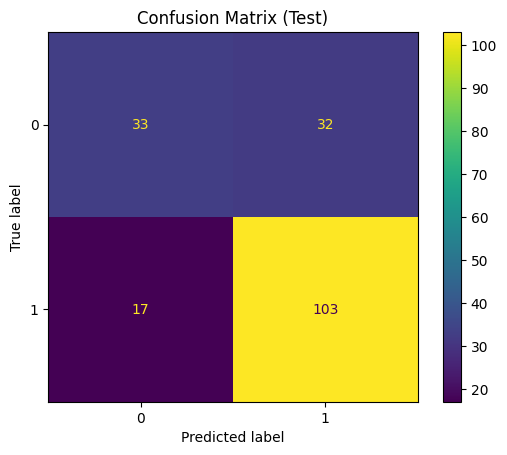

Precision (Test): 0.763
Recall (Test): 0.8583
Fold 1, ratio 0.55:


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Threshold: 0.5
AUC-ROC: 0.84
Accuracy: 0.82
Balanced Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.65      0.72        65
           1       0.83      0.92      0.87       120

    accuracy                           0.82       185
   macro avg       0.82      0.78      0.79       185
weighted avg       0.82      0.82      0.82       185

Confusion Matrix (Test):
[[ 42  23]
 [ 10 110]]


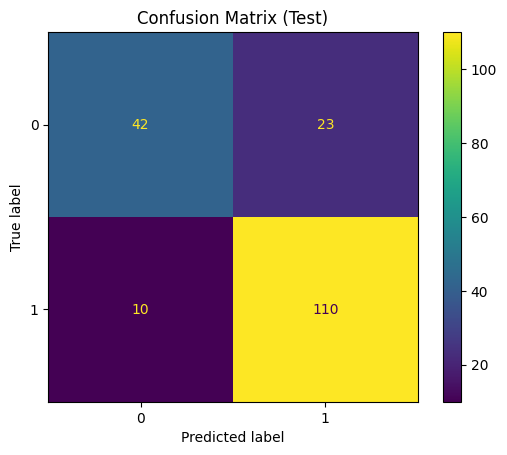

Precision (Test): 0.8271
Recall (Test): 0.9167
Fold 2, ratio 0.54:


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:29:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Threshold: 0.5
AUC-ROC: 0.77
Accuracy: 0.75
Balanced Accuracy: 0.71
Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.59      0.62        66
           1       0.79      0.83      0.81       119

    accuracy                           0.75       185
   macro avg       0.72      0.71      0.72       185
weighted avg       0.74      0.75      0.74       185

Confusion Matrix (Test):
[[39 27]
 [20 99]]


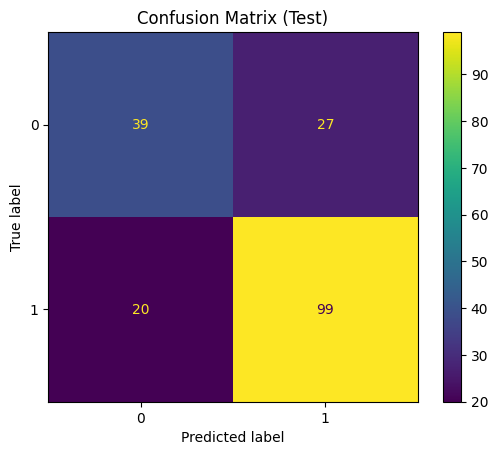

Precision (Test): 0.7857
Recall (Test): 0.8319
Fold 3, ratio 0.55:


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Threshold: 0.5
AUC-ROC: 0.86
Accuracy: 0.82
Balanced Accuracy: 0.79
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73        65
           1       0.84      0.89      0.87       119

    accuracy                           0.82       184
   macro avg       0.81      0.79      0.80       184
weighted avg       0.82      0.82      0.82       184

Confusion Matrix (Test):
[[ 45  20]
 [ 13 106]]


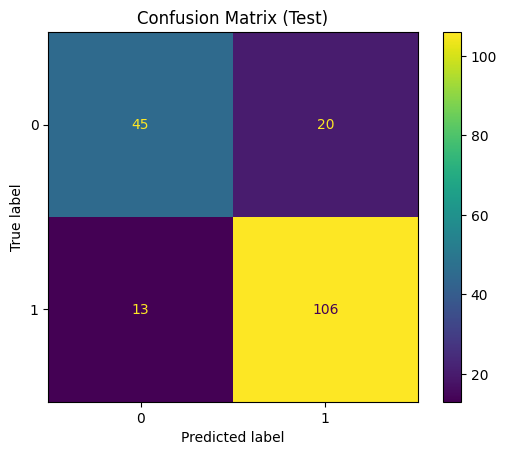

Precision (Test): 0.8413
Recall (Test): 0.8908
Fold 4, ratio 0.55:


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:29:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Threshold: 0.5
AUC-ROC: 0.84
Accuracy: 0.8
Balanced Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        65
           1       0.83      0.87      0.85       119

    accuracy                           0.80       184
   macro avg       0.78      0.77      0.78       184
weighted avg       0.80      0.80      0.80       184

Confusion Matrix (Test):
[[ 44  21]
 [ 16 103]]


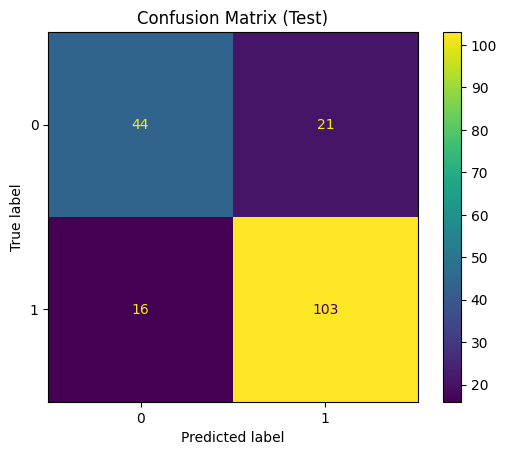

Precision (Test): 0.8306
Recall (Test): 0.8655


In [82]:
fold = 5
#np.zeros(fold)
for i, (train_index, test_index) in enumerate(cross_validation_generator(X, y, fold)):
  print(f"Fold {i}, ratio {round(get_ratio(y[train_index]), 2)}:")
  xgb_clf = train_xgb_model(X.iloc[train_index] ,  y[train_index])
  xgb_pred, xgb_prob = predict_model(xgb_clf, X.iloc[test_index])
  evaluate_model(y[test_index], xgb_pred, xgb_prob, threshold=0.5)

### single split

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:04:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Threshold: 0.5
AUC-ROC: 0.83
Accuracy: 0.8
Balanced Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.66      0.70        65
           1       0.83      0.88      0.85       120

    accuracy                           0.80       185
   macro avg       0.78      0.77      0.77       185
weighted avg       0.80      0.80      0.80       185

Confusion Matrix (Test):
[[ 43  22]
 [ 15 105]]


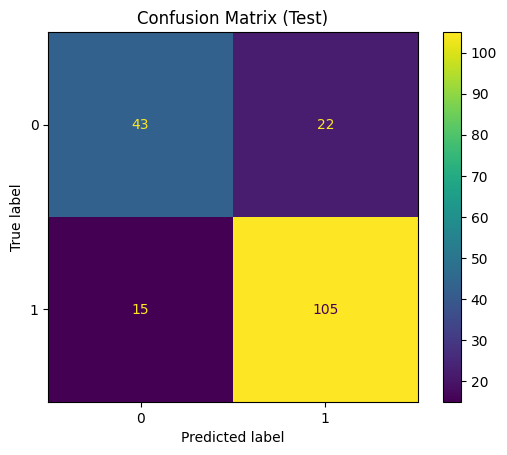

Precision (Test): 0.8268
Recall (Test): 0.875


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:04:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:04:12] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:04:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:04:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [10:04:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Cross-Validation Accuracy Scores: [0.68243243 0.79054054 0.83108108 0.78231293 0.7755102 ]
Mean Cross-Validation Accuracy: 0.77
Cross-Validation Balanced Accuracy Scores: [0.66266026 0.75921474 0.80168818 0.74453441 0.71315789]
Mean Cross-Validation Balanced Accuracy: 0.74
Cross-Validation AUC Scores: [0.75600962 0.8505609  0.83634558 0.82732794 0.7562753 ]
Mean Cross-Validation AUC: 0.81
Cross-Validation Precision Scores: [0.76923077 0.82178218 0.84313725 0.80582524 0.77192982]
Mean Cross-Validation Precision: 0.8
Cross-Validation Recall Scores: [0.72916667 0.86458333 0.90526316 0.87368421 0.92631579]
Mean Cross-Validation Recall: 0.86
Cross-Validation F1 Scores: [0.7486631  0.84263959 0.87309645 0.83838384 0.84210526]
Mean Cross-Validation F1: 0.83
Cross-Validation Kappa Scores: [0.31830655 0.53011061 0.62152209 0.50671141 0.46474677]
Mean Cross-Validation Kappa: 0.49


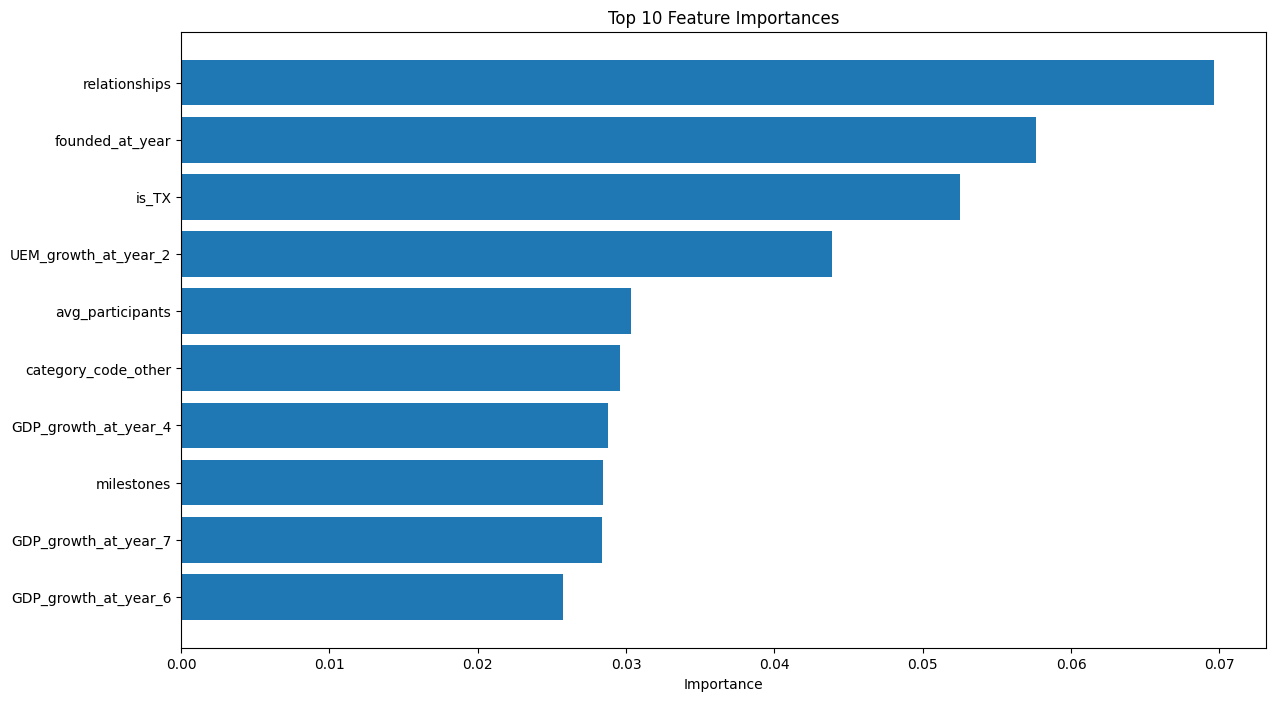

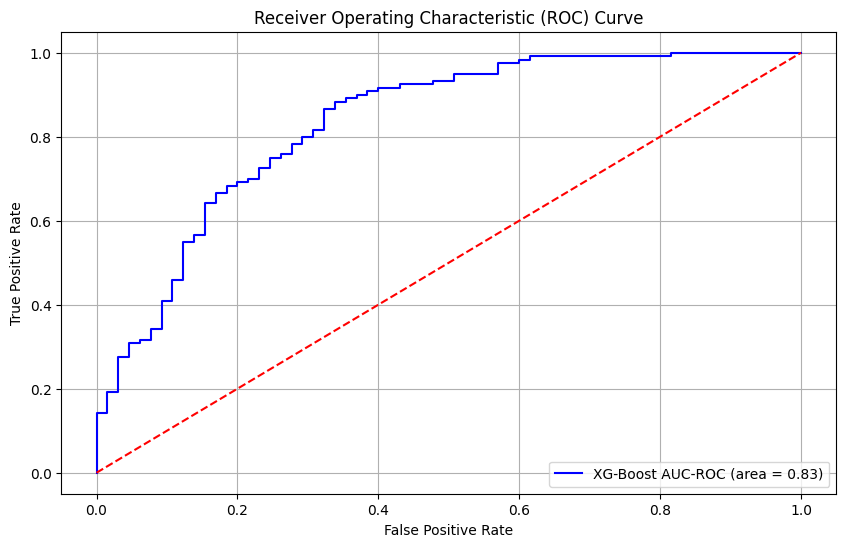

In [59]:
xgb_clf = train_xgb_model(X_train, y_train)
xgb_pred, xgb_prob = predict_model(xgb_clf, X_test)
evaluate_model(y_test, xgb_pred, xgb_prob, threshold=0.5)
cv_results_xgb = perform_cross_validation(xgb_clf, X_train, y_train, n_splits=5, random_state=random_state)

plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, xgb_prob, model_name='XG-Boost')

## Random Forest Ver2

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Threshold: 0.7
AUC-ROC: 0.85
Accuracy: 0.79
Balanced Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        65
           1       0.84      0.85      0.84       120

    accuracy                           0.79       185
   macro avg       0.78      0.77      0.77       185
weighted avg       0.79      0.79      0.79       185

Confusion Matrix (Test):
[[ 45  20]
 [ 18 102]]


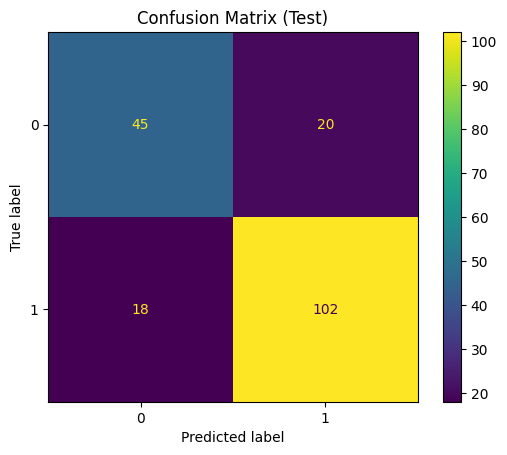

Precision (Test): 0.8361
Recall (Test): 0.85
Cross-Validation Accuracy Scores: [0.74324324 0.79054054 0.83108108 0.73469388 0.76870748]
Mean Cross-Validation Accuracy: 0.77
Cross-Validation Balanced Accuracy Scores: [0.71834936 0.75480769 0.79334657 0.67722672 0.70789474]
Mean Cross-Validation Balanced Accuracy: 0.73
Cross-Validation AUC Scores: [0.76602564 0.86057692 0.87130089 0.8208502  0.78137652]
Mean Cross-Validation AUC: 0.82
Cross-Validation Precision Scores: [0.80208333 0.81553398 0.83018868 0.75454545 0.7699115 ]
Mean Cross-Validation Precision: 0.79
Cross-Validation Recall Scores: [0.80208333 0.875      0.92631579 0.87368421 0.91578947]
Mean Cross-Validation Recall: 0.88
Cross-Validation F1 Scores: [0.80208333 0.84422111 0.87562189 0.8097561  0.83653846]
Mean Cross-Validation F1: 0.83
Cross-Validation Kappa Scores: [0.43669872 0.52583712 0.61490425 0.37920953 0.45113112]
Mean Cross-Validation Kappa: 0.48


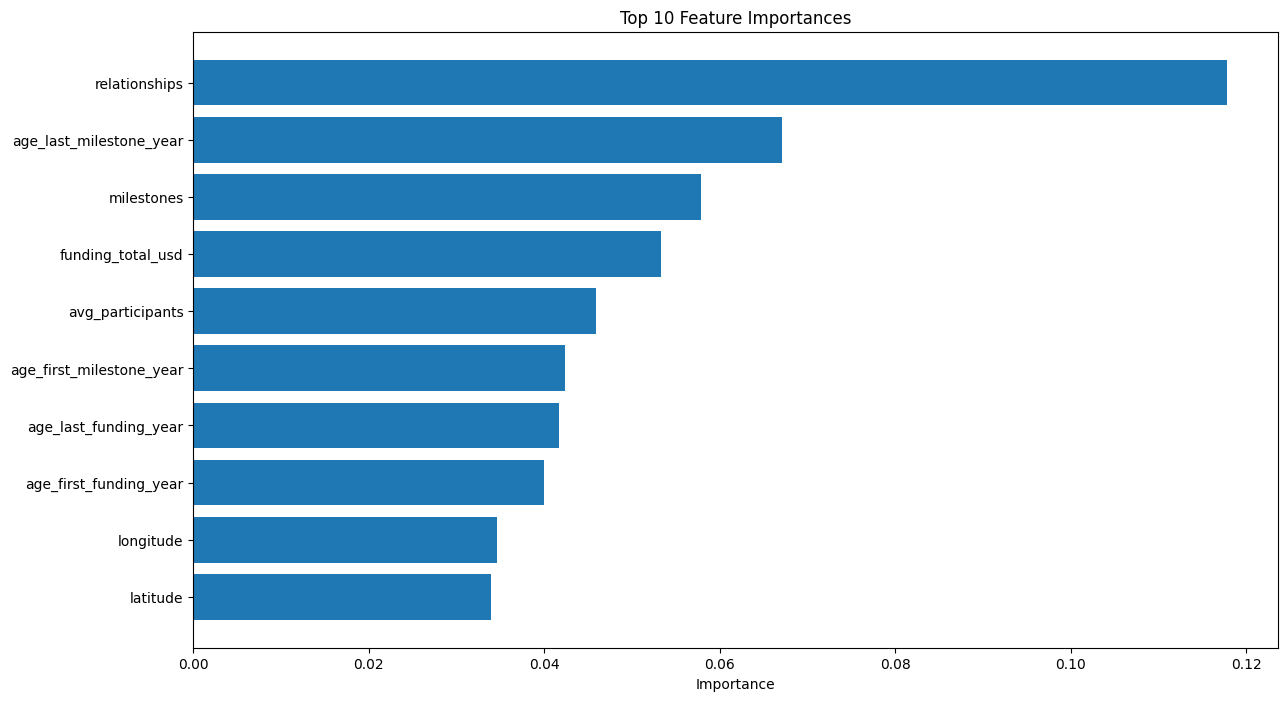

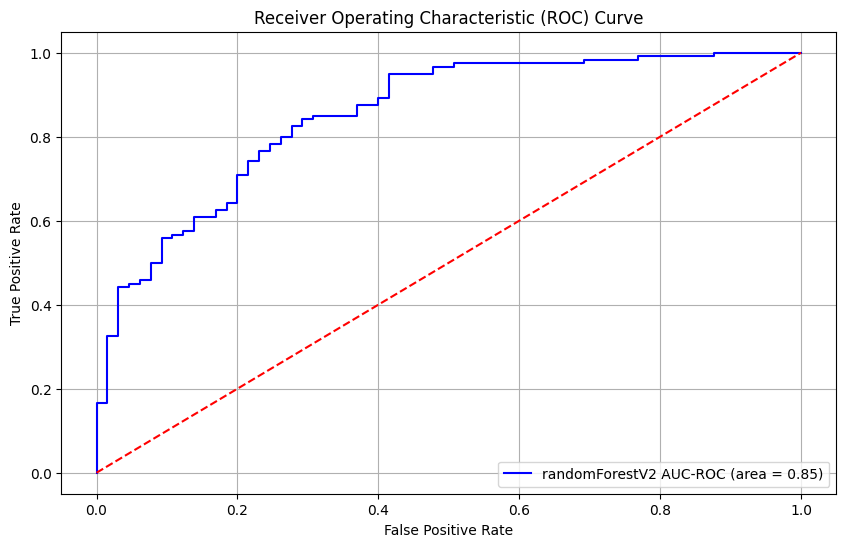

In [60]:
rfv2_clf = train_rfv2_model(X_train, y_train)
rfv2_pred, rfv2_prob = predict_model(rfv2_clf, X_test)
evaluate_model(y_test, rfv2_pred, rfv2_prob)
cv_results_rfv2 = perform_cross_validation(rfv2_clf, X_train, y_train, n_splits=5, random_state=random_state)

plot_feature_importances(rfv2_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, rfv2_prob, model_name='randomForestV2')

## Fandom Forest

Threshold: 0.7
AUC-ROC: 0.84
Accuracy: 0.79
Balanced Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        65
           1       0.82      0.87      0.84       120

    accuracy                           0.79       185
   macro avg       0.77      0.76      0.76       185
weighted avg       0.79      0.79      0.79       185

Confusion Matrix (Test):
[[ 42  23]
 [ 16 104]]


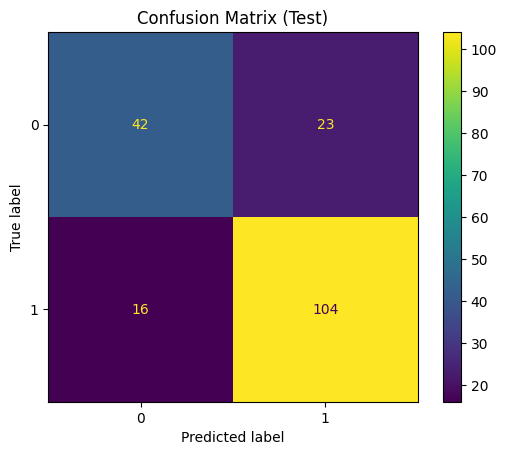

Precision (Test): 0.8189
Recall (Test): 0.8667
Cross-Validation Accuracy Scores: [0.77702703 0.79054054 0.83108108 0.75510204 0.78231293]
Mean Cross-Validation Accuracy: 0.79
Cross-Validation Balanced Accuracy Scores: [0.73116987 0.75480769 0.79334657 0.70607287 0.72277328]
Mean Cross-Validation Balanced Accuracy: 0.74
Cross-Validation AUC Scores: [0.75470753 0.86858974 0.87080437 0.82945344 0.79382591]
Mean Cross-Validation AUC: 0.82
Cross-Validation Precision Scores: [0.79439252 0.81553398 0.83018868 0.77570093 0.77876106]
Mean Cross-Validation Precision: 0.8
Cross-Validation Recall Scores: [0.88541667 0.875      0.92631579 0.87368421 0.92631579]
Mean Cross-Validation Recall: 0.9
Cross-Validation F1 Scores: [0.83743842 0.84422111 0.87562189 0.82178218 0.84615385]
Mean Cross-Validation F1: 0.85
Cross-Validation Kappa Scores: [0.48589474 0.52583712 0.61490425 0.4348569  0.48341753]
Mean Cross-Validation Kappa: 0.51


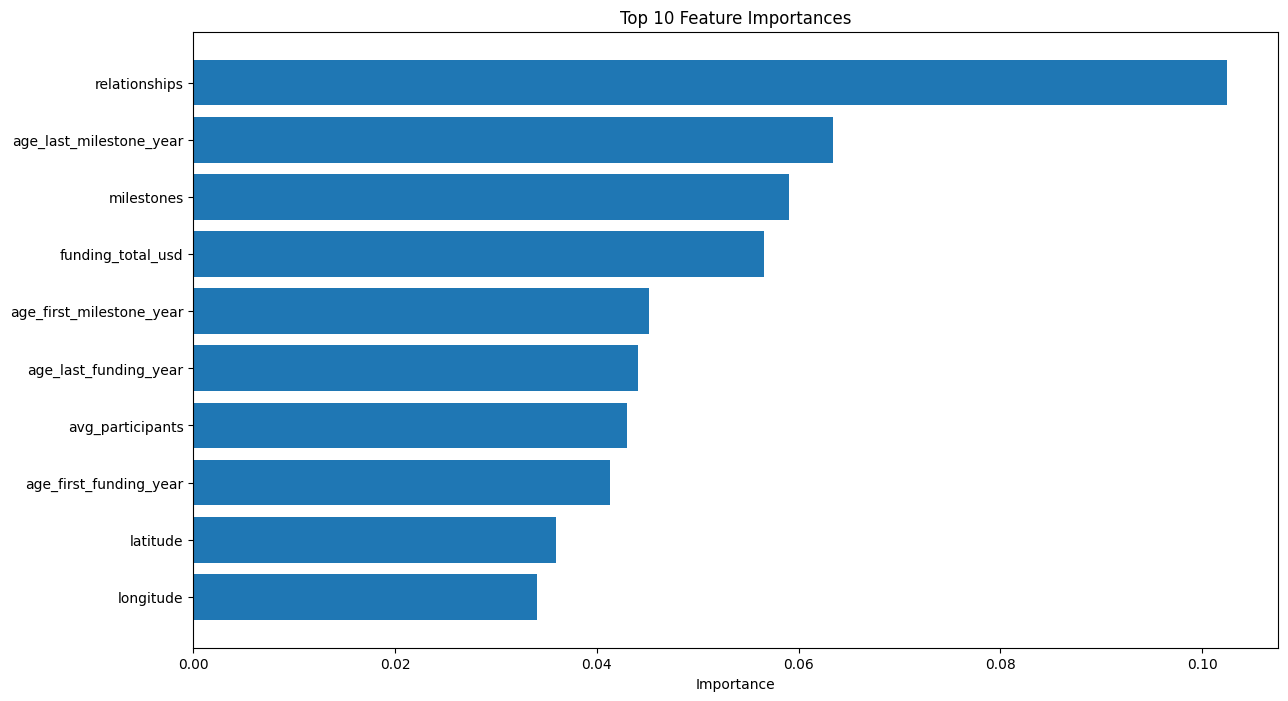

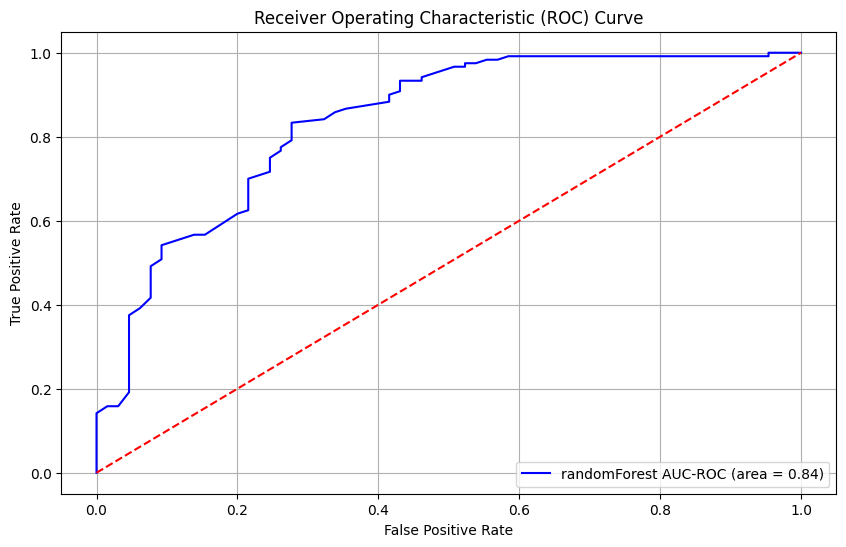

In [61]:
rf_clf = train_rf_model(X_train, y_train)
rf_pred, rf_prob = predict_model(rf_clf, X_test)
evaluate_model(y_test, rf_pred, rf_prob)
cv_results_rf = perform_cross_validation(rf_clf, X_train, y_train, n_splits=5, random_state=random_state)

plot_feature_importances(rf_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, rf_prob, model_name='randomForest')

## SVM

Threshold: 0.7
AUC-ROC: 0.81
Accuracy: 0.74
Balanced Accuracy: 0.69
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.52      0.59        65
           1       0.77      0.86      0.81       120

    accuracy                           0.74       185
   macro avg       0.72      0.69      0.70       185
weighted avg       0.73      0.74      0.73       185

Confusion Matrix (Test):
[[ 34  31]
 [ 17 103]]


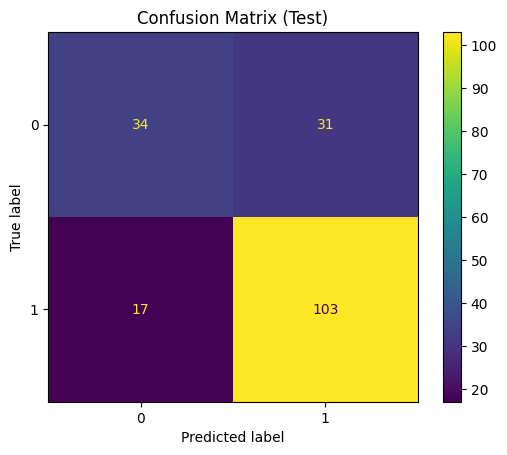

Precision (Test): 0.7687
Recall (Test): 0.8583
Cross-Validation Accuracy Scores: [0.68243243 0.77027027 0.78378378 0.74829932 0.76190476]
Mean Cross-Validation Accuracy: 0.75
Cross-Validation Balanced Accuracy Scores: [0.63621795 0.72596154 0.71062562 0.67904858 0.69827935]
Mean Cross-Validation Balanced Accuracy: 0.69
Cross-Validation AUC Scores: [0.71915064 0.82852564 0.84170804 0.79089069 0.75506073]
Mean Cross-Validation AUC: 0.79
Cross-Validation Precision Scores: [0.73786408 0.79245283 0.76033058 0.75       0.76315789]
Mean Cross-Validation Precision: 0.76
Cross-Validation Recall Scores: [0.79166667 0.875      0.96842105 0.91578947 0.91578947]
Mean Cross-Validation Recall: 0.89
Cross-Validation F1 Scores: [0.7638191  0.83168317 0.85185185 0.82464455 0.83253589]
Mean Cross-Validation F1: 0.82
Cross-Validation Kappa Scores: [0.2811079  0.47275775 0.4724883  0.3941183  0.43230718]
Mean Cross-Validation Kappa: 0.41


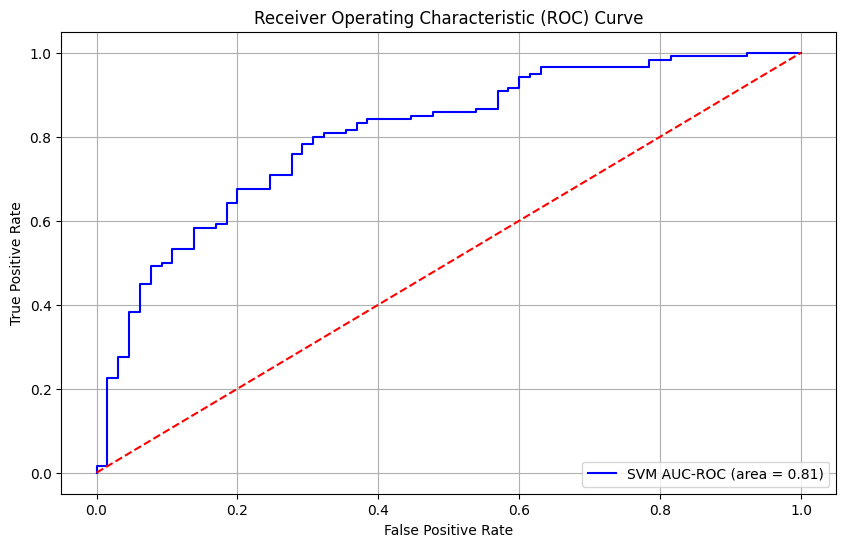

In [62]:
svm_clf = train_svm_model(X_train, y_train)
svm_pred, svm_prob = predict_model(svm_clf, X_test)
evaluate_model(y_test, svm_pred, svm_prob)
cv_results_SVM = perform_cross_validation(svm_clf, X_train, y_train, n_splits=5, random_state=42)

plot_auc_roc_curve(y_test, svm_prob, model_name='SVM')

# Ensemble classifiers

## Ensemble all

Threshold: 0.5
AUC-ROC: 0.85
Accuracy: 0.79
Balanced Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.69      0.70        65
           1       0.84      0.85      0.84       120

    accuracy                           0.79       185
   macro avg       0.78      0.77      0.77       185
weighted avg       0.79      0.79      0.79       185

Confusion Matrix (Test):
[[ 45  20]
 [ 18 102]]


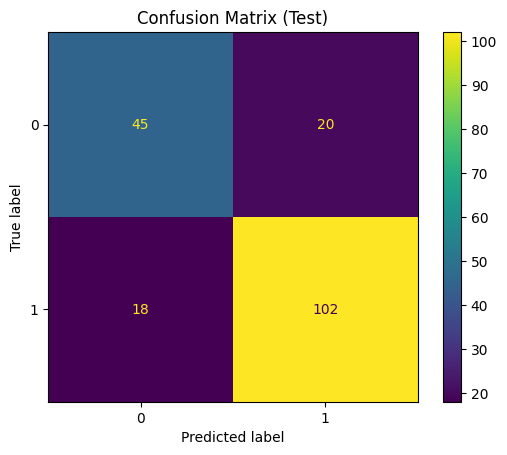

Precision (Test): 0.8361
Recall (Test): 0.85


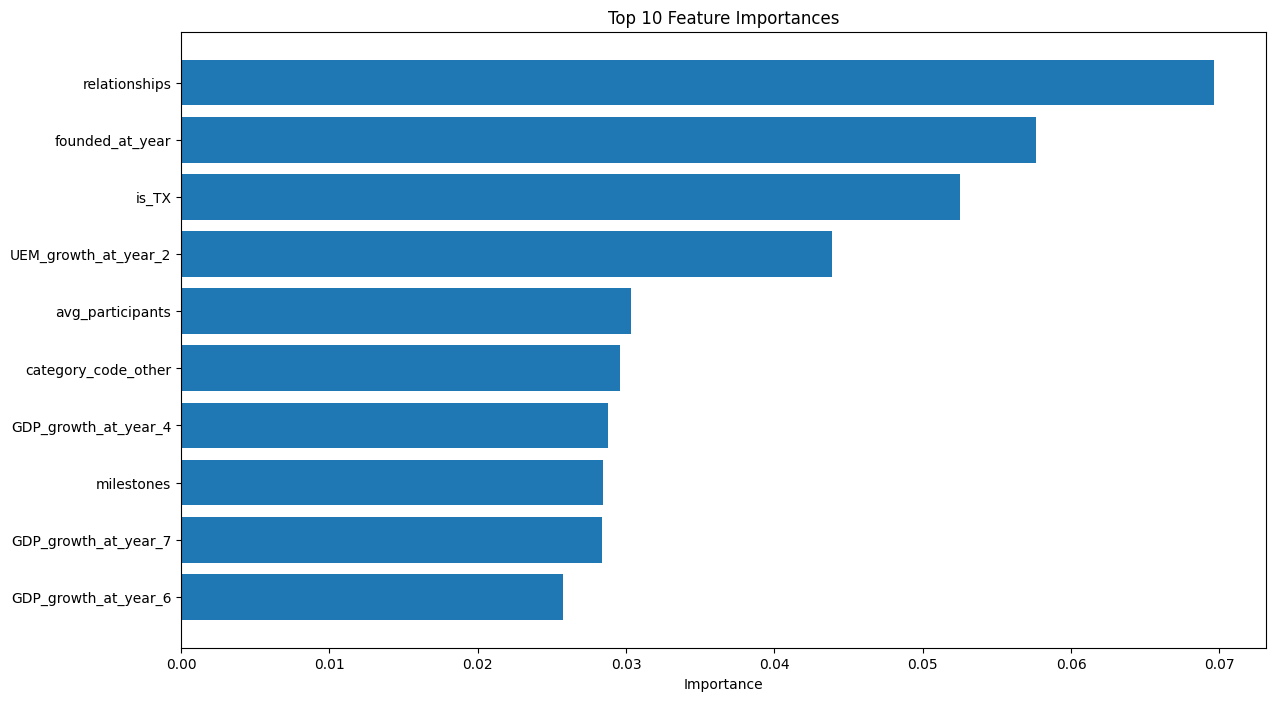

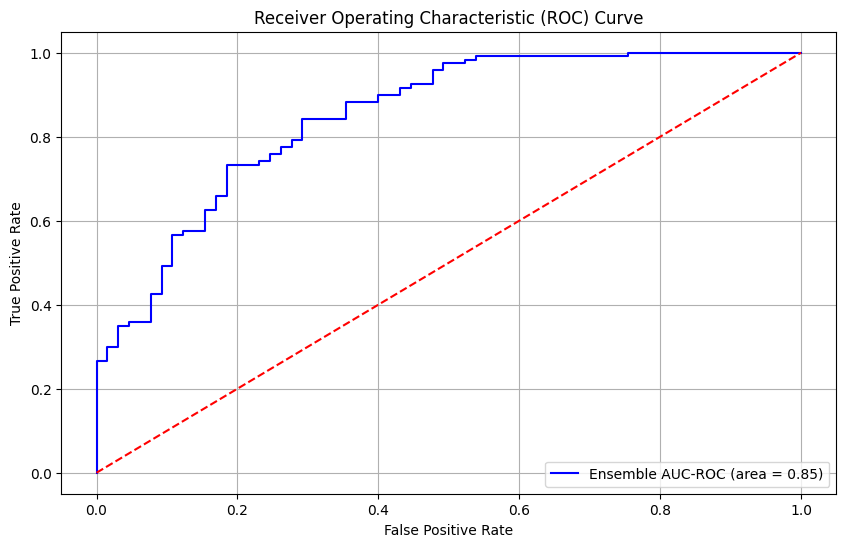

In [63]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, rf_pred, svm_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + rf_prob + svm_prob) / 4

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Ensemble with SVM

Threshold: 0.5
AUC-ROC: 0.85
Accuracy: 0.79
Balanced Accuracy: 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.65      0.68        65
           1       0.82      0.87      0.84       120

    accuracy                           0.79       185
   macro avg       0.77      0.76      0.76       185
weighted avg       0.79      0.79      0.79       185

Confusion Matrix (Test):
[[ 42  23]
 [ 16 104]]


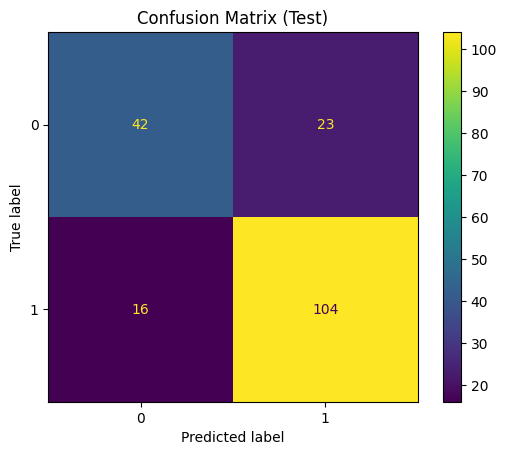

Precision (Test): 0.8189
Recall (Test): 0.8667


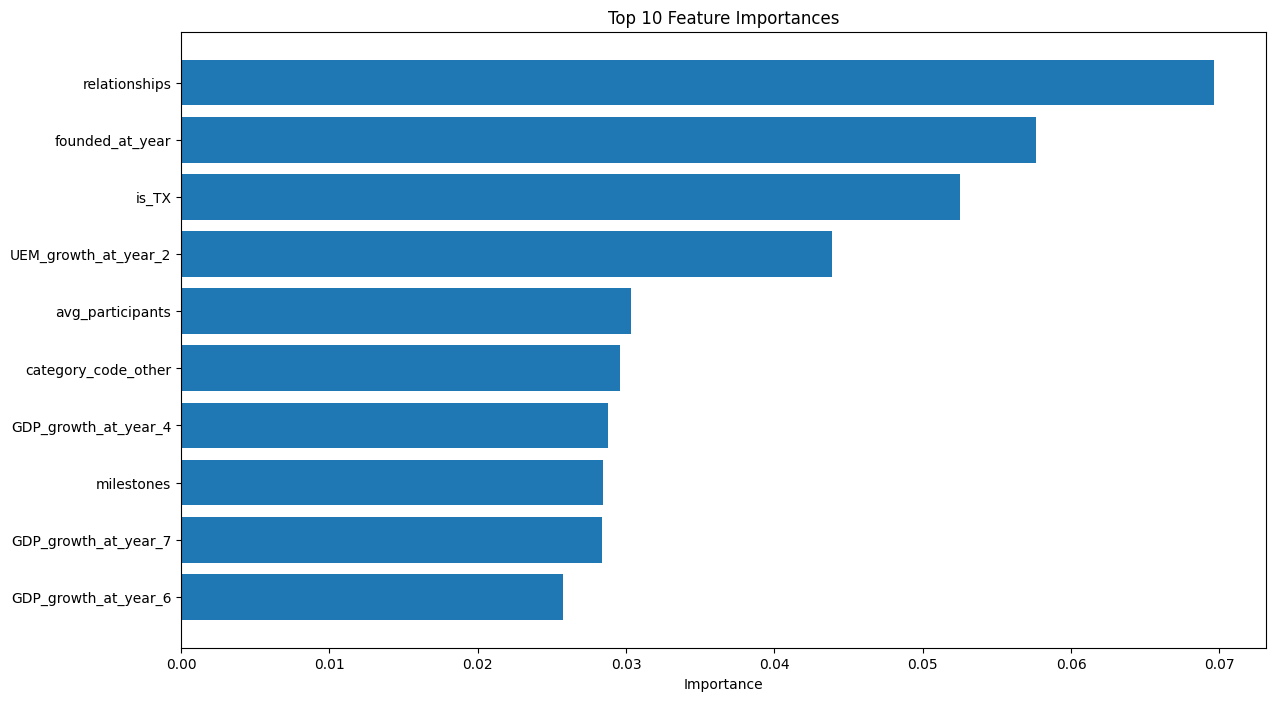

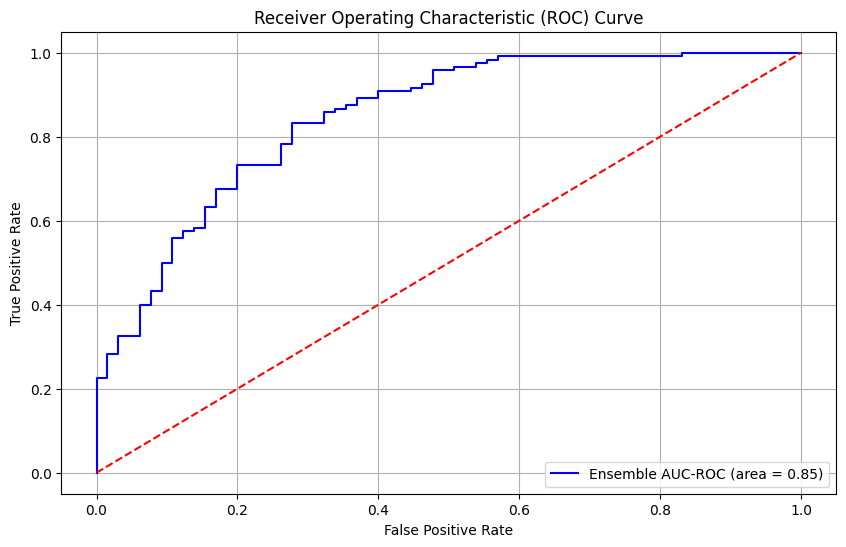

In [64]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, svm_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + svm_prob) / 3

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

## Ensemble without SVM

Threshold: 0.5
AUC-ROC: 0.85
Accuracy: 0.8
Balanced Accuracy: 0.77
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.68      0.70        65
           1       0.83      0.87      0.85       120

    accuracy                           0.80       185
   macro avg       0.78      0.77      0.78       185
weighted avg       0.80      0.80      0.80       185

Confusion Matrix (Test):
[[ 44  21]
 [ 16 104]]


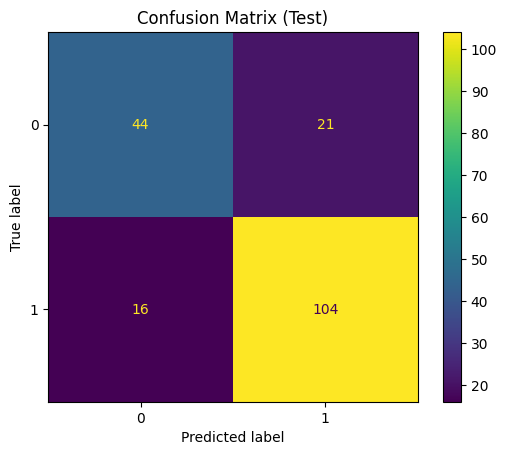

Precision (Test): 0.832
Recall (Test): 0.8667


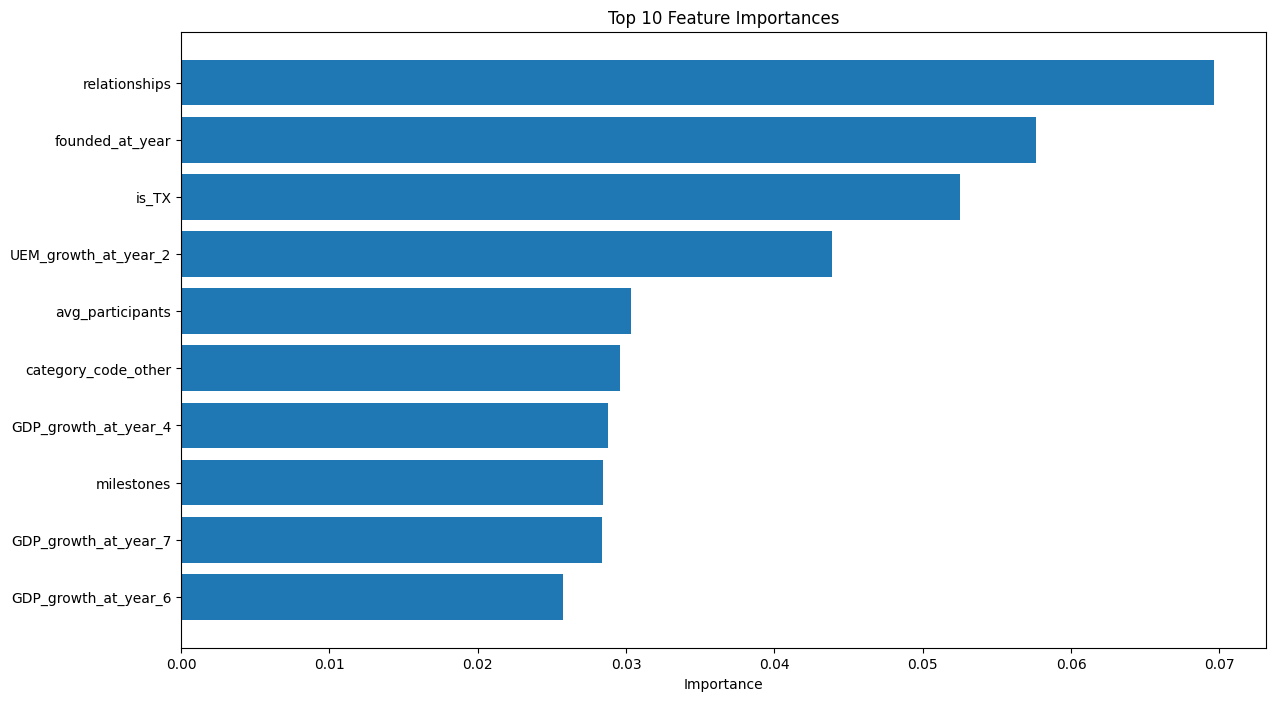

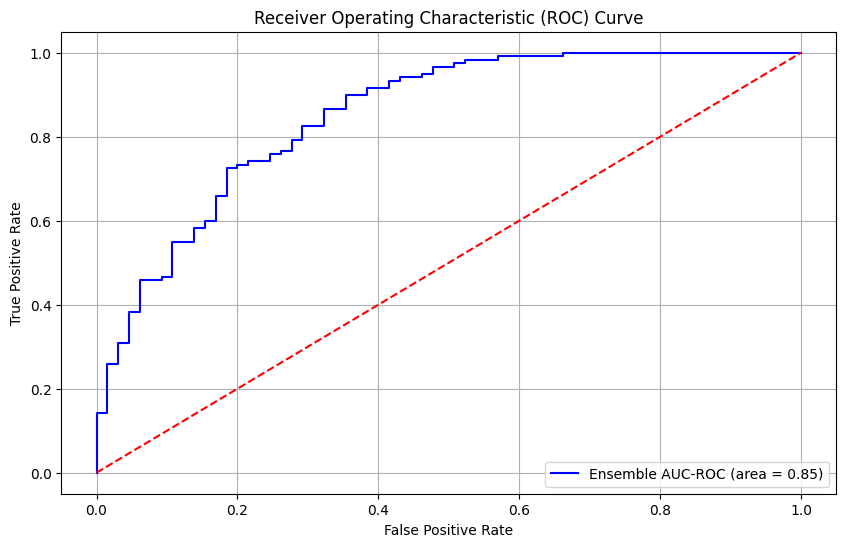

In [65]:
# Combine predictions using majority voting

# Stack the predictions into a matrix
predictions = np.vstack((xgb_pred, rfv2_pred, rf_pred)).T

# Majority voting
ensemble_pred, _ = mode(predictions, axis=1)
ensemble_pred = ensemble_pred.ravel()

# Combine probabilities (e.g., by averaging them)
ensemble_prob = (xgb_prob + rfv2_prob + rf_prob) / 3

# Evaluate the ensemble model
evaluate_model(y_test, ensemble_pred, ensemble_prob, threshold=0.5)

# Plot feature importances and AUC-ROC curves
plot_feature_importances(xgb_clf, feature_names=X.columns, num_of_features=10)
plot_auc_roc_curve(y_test, ensemble_prob, model_name='Ensemble')

# Analyse results

## Combine with the original features

In [66]:
import pandas as pd

# Create DataFrame with all features, y_test, and predictions
result_df = pd.DataFrame(X_test, columns=X.columns)
result_df['Actual'] = y_test.values
'''
result_df['Predicted_xgb'] = xgb_pred
result_df['Probability_xgb'] = xgb_prob
result_df['Predicted_rfv2'] = rfv2_pred
result_df['Probability_rfv2'] = rfv2_prob
result_df['Predicted_rf'] = rf_pred
result_df['Probability_rf'] = rf_prob
result_df['Predicted_svm'] = svm_pred
result_df['Probability_svm'] = svm_prob
'''
result_df['Predicted_ensemble'] = ensemble_pred
result_df['Probability_ensemble'] = ensemble_prob

# Display the DataFrame
result_df.head()

,category_code_advertising,category_code_analytics,category_code_automotive,category_code_biotech,category_code_cleantech,category_code_consulting,category_code_ecommerce,category_code_education,category_code_enterprise,category_code_fashion,...,UEM_growth_at_year_4,UEM_growth_at_year_5,UEM_growth_at_year_6,UEM_growth_at_year_7,UEM_growth_at_year_8,UEM_growth_at_year_9,UEM_growth_at_year_10,Actual,Predicted_ensemble,Probability_ensemble
739,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.604288,1.310711,0.893472,-0.504855,-1.289024,-1.124692,-0.892687,1,1,0.834382
789,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.698255,-0.002970,0.558446,0.922449,0.513016,-0.612743,-1.396864,1,1,0.668300
592,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.156248,0.529761,0.718045,1.069944,1.636902,2.155986,1.330940,1,1,0.826302
237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.035482,0.642984,1.165186,0.688725,-0.545468,-1.351670,-1.176347,0,0,0.221501
80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.698255,-0.002970,0.558446,0.922449,0.513016,-0.612743,-1.396864,1,1,0.780277


## try - drafts

In [67]:
df1 = load_data('../data/startup_data.csv')

In [68]:
plt.figure(figsize=(14, 5))

# Plot distribution for relationships on the left
plt.subplot(1, 2, 1)
sns.kdeplot(correct_original_df['relationships'], shade=True, label='Correct', color='g')
sns.kdeplot(incorrect_original_df['relationships'], shade=True, label='Incorrect', color='r')
plt.title('Distribution of "relationships"')
plt.legend()

# Plot distribution for founded_at_year on the right
plt.subplot(1, 2, 2)
sns.kdeplot(correct_original_df['founded_at_year'], shade=True, label='Correct', color='g')
sns.kdeplot(incorrect_original_df['founded_at_year'], shade=True, label='Incorrect', color='r')
plt.title('Distribution of "founded_at_year"')
plt.legend()

# Add a big title to the entire figure
plt.suptitle('High effect Feature Distributions for Correct and Incorrect Predictions', fontsize=16, y=1.05)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

NameError: name 'plt' is not defined

In [ ]:
df1.category_code.value_counts()

In [ ]:
result_df_ok = result_df[result_df['Predicted_ensemble'] == result_df['Actual']]
result_df_fail = result_df[result_df['Predicted_ensemble'] != result_df['Actual']]

print(result_df_ok['category_code_biotech'].value_counts() / len(result_df_ok))

In [ ]:
print(result_df_ok.category_code_biotech.value_counts())

In [ ]:
result_df_fail.category_code_finance.value_counts()

In [ ]:
result_df_fail['category_code_biotech'] = result_df_fail.category_code_biotech.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_biotech'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_biotech'].value_counts() )

In [ ]:
result_df_fail['category_code_software'] = result_df_fail.category_code_software.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['category_code_software'].value_counts() / len(result_df_fail))
print(result_df_fail['category_code_software'].value_counts() )

In [ ]:
result_df_fail['is_othercategory'] = result_df_fail.is_othercategory.apply(lambda x: 1 if x > 0.6 else 0)
#print(result_df_fail['is_othercategory'].value_counts() / len(result_df_fail))
print(result_df_fail['is_othercategory'].value_counts() )

In [ ]:
result_df.is_othercategory.value_counts()